# Test on synthetic data generated from the CRUST1.0 model

This notebook runs a more complex test using synthetic data generated from the CRUST1.0 model. The area will be restricted to South America and the model will use a homogeneous density contrast along the anomalous Moho. Thus, we'll only the Moho depth information from CRUST1.0. 

The test is meant to simulate what we expect from the real data application ([south-america-moho.ipynb](south-america-moho.ipynb)). We will assume that the reference Moho depth and density contrast are unknown. Both of these hyperparameters, along with the regularization parameter, will be determined through cross-validation. For the reference depth and density contrast, we'll use seismic point data to score solutions. These data will also be simulated using the CRUST1.0 model.

## Package imports

Load the necessary libraries to run the inversion and make graphs.

In [1]:
# Insert the plots into the notebook
%matplotlib inline

Load the standard scientific Python stack to numerical analysis and plotting.

In [2]:
from __future__ import division, print_function
import multiprocessing
import zipfile
import datetime
import pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn  # Makes the default style of the plots nicer

The computations generate a lot of run-time warnings. They aren't anything to be concerned about so disable them to avoid clutter.

In [3]:
import warnings
warnings.simplefilter('ignore')

Load the required modules from [Fatiando a Terra](http://www.fatiando.org).

In [4]:
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
import fatiando
from fatiando.mesher import Tesseroid

In [5]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 0.5


In [6]:
#Tesseroid?

Load our custom classes and functions.

In [7]:
from datasets import fetch_assumpcao_moho_points, fetch_crust1
from mohoinv import (MohoGravityInvSpherical, make_mesh, TesseroidRelief,
                     split_data, score_test_set, score_seismic_constraints, 
                     score_all, fit_all, predict_seismic)

Get the number of cores in this computer to run the some things in parallel.

In [8]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 8


## Generate the synthetic data

### Load the CRUST1 model for South America

Get the CRUST1.0 data from the archive file and cut it to South America.

In [9]:
crust1 = fetch_crust1('../data/crust1.0.tar.gz').cut((-60, 20, -90, -30))

Establish a reference level for the Moho of the Normal Earth (given as height above the ellipsoid in meters, thus it is negative).

In [10]:
reference = -30e3

Create a `TesseroidRelief` model of the Moho using a homogeneous density-contrast so that we can use in forward modeling.

In [11]:
moho_density_contrast = 350

In [12]:
model = TesseroidRelief(crust1.area, crust1.shape, relief=-crust1.moho_depth.ravel(), 
                        reference=reference)
density = moho_density_contrast*np.ones(model.size)
density[model.relief < model.reference] *= -1
model.addprop('density', density)

In [13]:
print('Tesseroids in the model (M_lat x M_lon): {} x {} = {}'.format(
    model.shape[0], model.shape[1], model.size))

Tesseroids in the model (M_lat x M_lon): 80 x 60 = 4800


Make a plot of the Moho depth using an appropriate map projection.

In [14]:
bm = Basemap(projection='cyl', 
             llcrnrlon=crust1.area[2], urcrnrlon=crust1.area[3], 
             llcrnrlat=crust1.area[0], urcrnrlat=crust1.area[1],
             resolution='l')

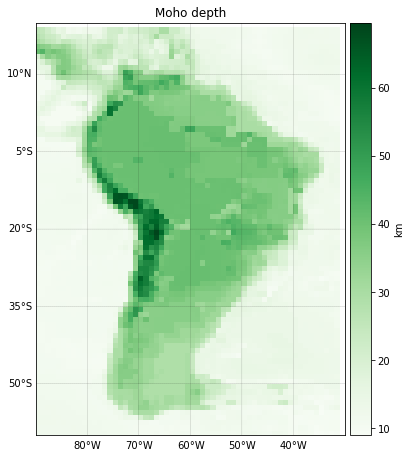

In [15]:
x, y = bm(model.lon.reshape(model.shape), model.lat.reshape(model.shape))

plt.figure(figsize=(7, 6))
plt.title('Moho depth')
bm.pcolormesh(x, y, -0.001*model.relief.reshape(model.shape), cmap='Greens')
plt.colorbar(pad=0.01).set_label('km')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout(pad=0)

### Forward model the synthetic data

Generate the computation grid for our synthetic dataset. The grid will have half the spacing of the model. This way, we'll have more points than we'll need to run the inversion. The extra points will be separated into a *test dataset* for cross-validation (see section [Cross-validation](#Cross-validation) below).

In [16]:
# clon and clat are the coordinates of the center of each model cell
area = [model.clat.min(), model.clat.max(), model.clon.min(), model.clon.max()]
# Increase the shape to have half the grid spacing
full_shape = [s*2 - 1 for s in model.shape]
grid_height = 50e3
full_lat, full_lon, full_height = gridder.regular(area, full_shape, z=grid_height)
print('Number of grid points: {} x {} = {}'.format(full_shape[0], full_shape[1], 
                                                   full_shape[0]*full_shape[1]))
print('Grid height: {} m'.format(grid_height))

Number of grid points: 159 x 119 = 18921
Grid height: 50000.0 m


Calculate the synthetic data and contaminate it with pseudo-random gaussian noise.

In [17]:
full_data_noisefree = tesseroid.gz(full_lon, full_lat, full_height, model, njobs=ncpu)

In [67]:
full_data = utils.contaminate(full_data_noisefree, 5, seed=0)

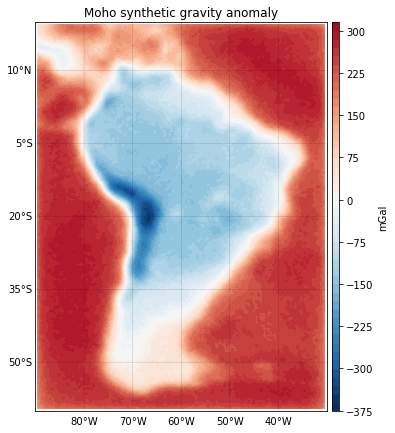

In [68]:
x, y = bm(full_lon, full_lat)
ranges = np.abs([full_data.min(), full_data.max()]).max()

plt.figure(figsize=(7, 6))
plt.title('Moho synthetic gravity anomaly')
bm.contourf(x, y, full_data, 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

### Save the synthetic data and model

We'll save the generated data and the corresponding model for later use and plotting. The data will be saved to the text file [../data/synthetic-data-crust1.txt](../data/synthetic-data-crust1.txt).

In [69]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
header = """# Generated by sinthetic-crust1.ipynb on {date}
# shape (nlat, nlon):
# {nlat} {nlon}
# lat lon height gravity_anomaly_noisefree gravity_anomaly_noisy
""".format(date=now, nlat=full_shape[0], nlon=full_shape[1])
with open('../data/synthetic-data-crust1.txt', 'w') as f:
    f.write(header)
    np.savetxt(f, np.c_[full_lat, full_lon, full_height, full_data_noisefree, full_data],
               fmt='%.5f')

The model we'll save to a [Python pickle](https://docs.python.org/2/library/pickle.html) file. The `pickle` module allows us to serialize an object and load it back later. We'll use it to serialize the `model` object and save the file to the `model` folder.

In [70]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
model.metadata = "Generated by sinthetic-crust1.ipynb on {date}".format(date=now)
with open('../model/synthetic-crust1.pickle', 'w') as f:
    pickle.dump(model, f)

## Cross-validation

First, we must separate the dataset into two parts: one for the inversion, another for cross-validation. The inversion dataset will have double the grid spacing and (for this test) must fall on top of each grid cell. The remaining data will be used for cross-validation.

In [71]:
inversion_set, test_set, shape = split_data([full_lat, full_lon, full_height, full_data], 
                                            full_shape, every_other=2)

print("Number of inversion grid points: {} x {} = {}".format(shape[0], shape[1], 
                                                             shape[0]*shape[1]))
print("Number of test set points: {}".format(test_set[0].size))

Number of inversion grid points: 80 x 60 = 4800
Number of test set points: 14121


Test if the inversion set falls on top of the model cells.

In [72]:
lat, lon, height, data = inversion_set
assert np.allclose(model.clon.ravel(), lon, rtol=1e-10, atol=0)
assert np.allclose(model.clat.ravel(), lat, rtol=1e-10, atol=0)

No errors means that both checks (`assert`) passed.

Check if the score for the true model and error free data is 0 (perfect fit).

In [73]:
score_test_set(model, full_lat, full_lon, full_height, full_data_noisefree, njobs=ncpu)

7.9384116080629576

For this test, we'll assume that we **don't know the true reference level used or density contrast**. We'll try to estimate both through cross-validation. This means that there will be **two types of cross-validation**: 

1. Testing agains the `test_set` for the regularization parameter
2. Testing against some other constraints for the reference level and density contrast

These "other constraints" will come some point information about the Moho depth in some isolated points. In reality, these point depths could come from seismic experiments.

We'll generate some fictional point constraints by taking the true value from our Moho model. The point coordinates chosen for this come from the seismic dataset of [Assumpção et al. (2013)](http://dx.doi.org/10.1016%2Fj.tecto.2012.11.014). We'll interpolate the values of the CRUST1 Moho depth onto these points.

In [74]:
tmp = fetch_assumpcao_moho_points('../data/Moho_Map_SAm2013_data.tar.gz')
lat_points, lon_points = tmp[:2]

In [75]:
seismic_points = gridder.interp_at(model.clat.ravel(), model.clon.ravel(), 
                                   model.relief, lat_points, lon_points)

In [76]:
print('Number of seismic points: {}'.format(seismic_points.size))

Number of seismic points: 937


In [77]:
test_points = [lat_points, lon_points, seismic_points]

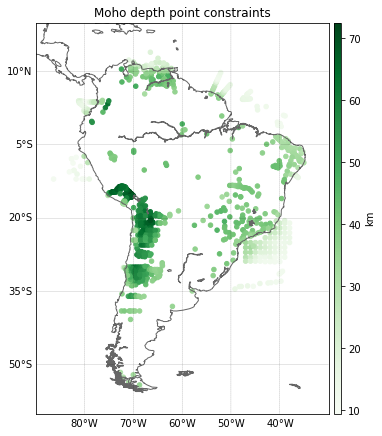

In [78]:
x, y = bm(lon_points, lat_points)

plt.figure(figsize=(7, 6))
plt.title('Moho depth point constraints')
bm.scatter(x, y, c=-0.001*seismic_points, s=20, cmap='Greens')
plt.colorbar(pad=0.01, aspect=50).set_label('km')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
bm.drawcoastlines(color="#666666")
plt.tight_layout()

ZWe can check if our scoring function from [mohoinv.py](mohoinv.py) works by feeding it the true model and the extracted points. The MSE should be zero.

In [79]:
score_seismic_constraints(model, lat_points, lon_points, seismic_points)

0.0

Save our synthetic seismic constraints to a file so that we can plot it later.

In [80]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
header = """# Synthetic point estimates of Moho depth (from CRUST1.0)
# Generated by sinthetic-crust1.ipynb on {date}
# Moho depth is given in meters.
# lat lon depth
""".format(date=now)
with open('../data/crust1-point-depths.txt', 'w') as f:
    f.write(header)
    np.savetxt(f, np.c_[lat_points, lon_points, -seismic_points],
               fmt='%.5f')

## Inversion setup

We need to generate a `TesseroidRelief` mesh for the inversion, give it a reference level and a density contrast. We'll assume that our mesh has the same geometry of the true model so that we can better compare the estimated and true Moho reliefs.

In [81]:
mesh = model.copy(deep=True)

We'll also need an initial estimate, the solver and its configuration, and a regularization object.

In [82]:
misfit = MohoGravityInvSpherical(lat, lon, height, data, mesh)
regul = Smoothness2D(mesh.shape)
initial = -60e3*np.ones(mesh.size)  
# The initial estimate doesn't really matter too much

## Plotting functions

We'll define some plotting functions here to avoid having all this code down with the results. You can safely skip (not read) this section because we only define the functions here. They are called after the inversion below.

In [83]:
def plot_fit(lat, lon, data, solution, bm):    
    ranges = np.abs([data.max(), data.min()]).max()
    
    plt.figure(figsize=(7, 6))
    plt.title('Observed (color) and predicted (contour) data')    
    levels = mpl.contourf(lon, lat, data, shape, 40, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, solution[0].predicted(), shape, levels, 
                basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_residuals(solution):
    residuals = solution[0].residuals()
    
    plt.figure(figsize=(3, 2.5))
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
def plot_estimate(solution, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 6))
    plt.title("Estimated Moho depth")
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)

def plot_diff(solution, model, bm):
    moho = solution.estimate_
    diff = -0.001*(model.relief - moho.relief).reshape(moho.shape)
    ranges = np.abs([diff.max(), diff.min()]).max()
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 6))
    plt.title("Difference between true and estimated")  
    bm.pcolormesh(x, y, diff, cmap='RdYlBu_r', vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    plt.tight_layout(pad=0)
    
def plot_diff_hist(solution, model):
    moho = solution.estimate_
    diff = -0.001*(model.relief - moho.relief)
    
    plt.figure(figsize=(3, 2.5))
    plt.title('Difference (true model)')
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(diff.mean(), diff.std()), 
             transform=plt.gca().transAxes) 
    # Use the line above so the text coordinates are in axes coordinates (0 to 1)
    # instead of data coordinates, which may vary between runs.
    plt.hist(diff.ravel(), bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Differences (km)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
def plot_diff_seismic(solution, test_points, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    diff = -0.001*(test_points[-1] - predict_seismic(moho, *test_points[:2]))
    ranges = np.abs([diff.max(), diff.min()]).max()
    lat, lon, depth = test_points
    xp, yp = bm(lon, lat)
   
    fig = plt.figure(figsize=(7, 6))
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01, aspect=50).set_label('Estimated Moho depth (km)')
    bm.scatter(xp, yp, c=diff, s=40, cmap='PuOr_r', 
                     vmin=-ranges, vmax=ranges, linewidths=0.1)
    cb = plt.colorbar(pad=0.01, aspect=50)
    cb.set_label('Difference between estimated and seismic (km)')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 1, 0], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_diff_seismic_hist(solution, test_points):
    moho = solution.estimate_
    diff = -0.001*(test_points[-1] - predict_seismic(moho, *test_points[:2]))

    plt.figure(figsize=(3, 2.5))
    plt.title('Difference (seismic points)')
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(diff.mean(), diff.std()), 
             transform=plt.gca().transAxes)
    # Use the line above so the text coordinates are in axes coordinates (0 to 1)
    # instead of data coordinates, which may vary between runs.
    plt.hist(diff, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Differences (km)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)

def plot_cv_regul(regul_params, scores, best, log=True): 
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (regularization parameter)')
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout(pad=0)
    
def plot_cv_ref_dens(densities, reference_levels, scores, best_dens, best_ref):
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (reference level and density)')
    plt.contourf(-0.001*reference_levels, densities, scores, 30, cmap='BuPu_r')
    plt.colorbar(pad=0.01).set_label('Mean Square Error')
    plt.plot(-0.001*reference_levels[best_ref], densities[best_dens], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    l = plt.legend(loc='upper left')
    for txt in l.get_texts():
        txt.set_color('#ffffff')
    plt.xlabel('Reference level (km)')
    plt.ylabel(u'Density contrast (kg/m³)')
    plt.tight_layout(pad=0)
    
def plot_convergence(solution, log=True):
    plt.figure(figsize=(5, 3))
    plt.title('Convergence')
    plt.plot(range(solution.stats_['iterations'] + 1), solution.stats_['objective'])
    plt.xlabel('Iteration')
    plt.ylabel('Goal function')
    if log:
        plt.yscale('log')
    plt.tight_layout(pad=0)

## Run the inversion and cross-validations

We'll keep the results in a Python dictionary (`dict`) along with all configuration and other metadata. We can then save this dict to a Pickle file and have inversion information saved with the results.

In [84]:
results = dict()

Save also the configuration for the solver. We'll use the Gauss-Newton formulation of the inversion.

In [85]:
results['config'] = dict(method='newton', initial=initial, tol=0.2, maxit=15)

These are the values of the regularization parameter, reference level, and density contrast that we'll use.

In [86]:
results['regul_params'] = np.logspace(-5, -3, 3)
results['regul_params']

array([  1.00000000e-05,   1.00000000e-04,   1.00000000e-03])

In [87]:
results['reference_levels'] = np.arange(-32.5e3, -27.5e3 + 1, 2500)
results['reference_levels']

array([-32500., -30000., -27500.])

In [88]:
results['densities'] = np.arange(300, 400 + 1, 50)
results['densities']

array([300, 350, 400])

First, run the cross-validation to find the regularization parameter. We'll use one of the values for the reference and density contrast. The value of the regularization parameter that we estimate here will be used in the second cross-validation to find the density contrast and reference level.

In [89]:
misfit.set_density(results['densities'][-1]).set_reference(results['reference_levels'][-1])

Run the inversion for each value in `regul_params` (in parallel using all available cores). 

In [90]:
solvers = [(misfit + mu*regul).config(**results['config']) 
           for mu in results['regul_params']]

%time solutions = fit_all(solvers, njobs=ncpu)

Wall time: 3min 43s


Keep only the estimated models in the results dict instead of the whole solvers to reduce the size of the pickle file. We can calculate the predicted data, etc, from the model only.

In [91]:
results['models_regul'] = [s.estimate_ for s in solutions]

Score the results against the test dataset.

In [92]:
%%time 
results['scores_regul'] = score_all(results['models_regul'], test_set, 
                                    points=False, njobs=ncpu)

Wall time: 1min 12s


The best solution is the one with the smallest cross-validation score.

In [93]:
best_regul = np.argmin(results['scores_regul'])
results['best_regul'] = best_regul

We'll use this solution as the inversion solver for the next cross-validation (for the reference level and density).

In [94]:
results['solution_regul'] = solutions[best_regul]

But first, let's take a look at the current solution.

Plot the cross-validation scores.

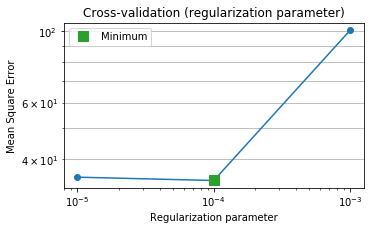

In [95]:
plot_cv_regul(results['regul_params'], results['scores_regul'], 
              results['best_regul'], log=True)
plt.grid(True, which='both', axis='y')

The inversion residuals (to see if the solution fits the data).

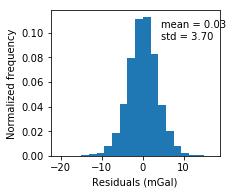

In [96]:
plot_residuals(results['solution_regul'])

The solution itself to see if it is smooth enough.

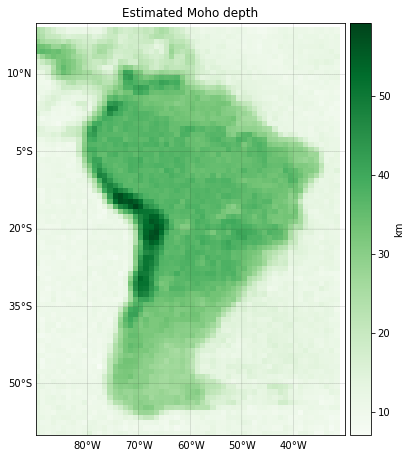

In [97]:
plot_estimate(results['solution_regul'], bm)

Now, run the second cross-validation to estimate the density-contrast and the reference level.

In [98]:
def set_ref_dens(solver, ref, dens):
    """
    Configure the solver to use this reference level and density.
    """
    res = solver.copy(deep=True)
    # res is a multi-objective with the misfit function + regularization
    # res[0] is the misfit (our inversion class)
    # res[1] is the Smoothness2D instance
    res[0].set_density(dens).set_reference(ref)
    return res

In [99]:
solvers = [set_ref_dens(results['solution_regul'], ref, dens) 
           for dens in results['densities'] 
           for ref in results['reference_levels']]

%time solutions = fit_all(solvers, njobs=ncpu)

Wall time: 7min 21s


Keep the only the estimated models in the results dict.

In [100]:
results['models_refdens'] = [s.estimate_ for s in solutions]

Score the estimates against the seismic constraints.

In [101]:
cv_shape = (len(results['densities']), len(results['reference_levels']))

Putting this step into a for loop

In [102]:
%%time

# for loop set array of certain size e.g. 624 and put into set_train definition
# after score is calculated need to put into array to store all values
train_size = np.array([703]) # for loop in for loop. loop with a bunch of different training sizes
iteration_number = 1
MSE_values = np.empty([train_size.size, iteration_number])
for j in range(train_size.size):
    for i in range(iteration_number):
        indices = np.arange(lat_points.size)
        set_train = np.random.choice(indices, size=train_size[j], replace=False)
        lat_train = lat_points[set_train]
        lon_train = lon_points[set_train]
        seis_train = seismic_points[set_train]
        train_points = [lat_train, lon_train, seis_train]
        lat_test = np.delete(lat_points, set_train)
        lon_test = np.delete(lon_points, set_train)
        seismic_test = np.delete(seismic_points, set_train)
        results['scores_refdens'] = score_all(results['models_refdens'], train_points, 
                                              points=True, njobs=ncpu).reshape(cv_shape)
        best = np.nanargmin(results['scores_refdens'])
        results['solution'] = solutions[best]
            # Find the index in reference_levels and densities corresponding to best
        MSE_values[j, i] = score_seismic_constraints(results['solution'].estimate_, lat_test, lon_test, seismic_test)
print(MSE_values) #np.save function to save results
#np.save('MSE_values_703.npy',MSE_values)
# after done put this code into south american moho

[[ 6255914.15297598]]
Wall time: 20 s


In [103]:
np.isnan(MSE_values) #np.any

array([[False]], dtype=bool)

Text(0,0.5,'Frequency')

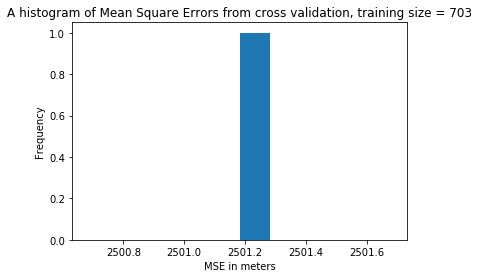

In [104]:
#plotting MSE for training size 703 or about 3/4 of data
plt.figure()
plt.title("A histogram of Mean Square Errors from cross validation, training size = 703")
plt.hist(np.sqrt(MSE_values[0, :]))
plt.xlabel("MSE in meters")
plt.ylabel("Frequency")
#plt.savefig("MSE_training_size_703.jpg", dpi=100, bbox_inches="tight")


In [105]:
results['solution'] = solutions[best]
# Find the index in reference_levels and densities corresponding to best
results['best_dens'], results['best_ref'] = np.unravel_index(best, cv_shape)

Print the estimated parameters:

In [106]:
estimated_ref = results['reference_levels'][results['best_ref']]
estimated_dens = results['densities'][results['best_dens']]
estimated_regul = results['regul_params'][results['best_regul']]
print('Cross-validation results:')
print(u'  reference level: {} km (true = {})'.format(
    -0.001*estimated_ref, -0.001*reference))
print(u'  density contrast: {} kg/m³ (true = {})'.format(
    estimated_dens, moho_density_contrast))
print(u'  regularization parameter: {}'.format(estimated_regul))

Cross-validation results:
  reference level: 30.0 km (true = 30.0)
  density contrast: 350 kg/m³ (true = 350)
  regularization parameter: 0.0001


Plot the cross-validation score for the reference level and density-contrast on map.

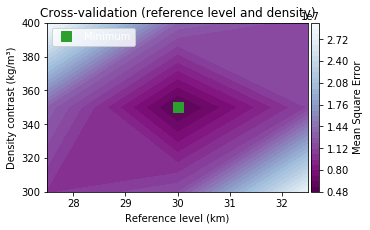

In [107]:
plot_cv_ref_dens(results['densities'], results['reference_levels'], 
                 results['scores_refdens'], results['best_dens'], results['best_ref'])

### Save the results to a pickle file

All of the above takes some time to run. We can now save the `results` dictionary to a pickle file and load it later to make plots of the results without re-calculating. Since the resulting pickle file will be large, we'll store it in a `zip` archive.

In [108]:
# Dump the results dict to a pickle file
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
results['metadata'] = "Generated by sinthetic-crust1.ipynb on {date}".format(date=now)
fname = 'synthetic-crust1'
pickle_file = '{}.pickle'.format(fname)
with open('results/{}'.format(pickle_file), 'w') as f:
    pickle.dump(results, f)   
# Zip the pickle file
zipargs = dict(mode='w', compression=zipfile.ZIP_DEFLATED)
with zipfile.ZipFile('results/{}.zip'.format(fname), **zipargs) as f:
    f.write('results/{}'.format(pickle_file), arcname=pickle_file)

### Plot the final solution

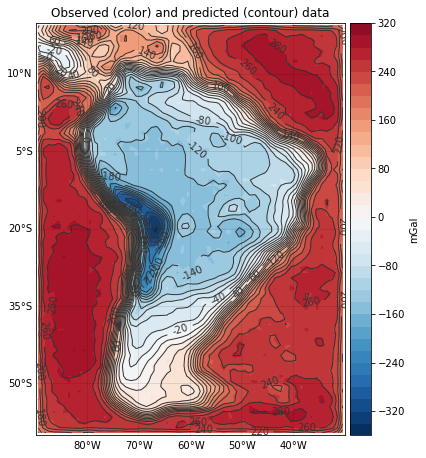

In [109]:
plot_fit(lat, lon, data, results['solution'], bm)

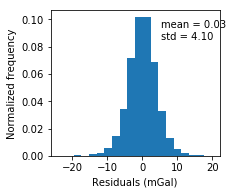

In [110]:
plot_residuals(results['solution'])

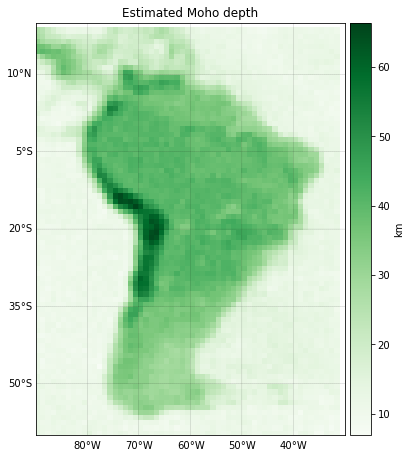

In [111]:
plot_estimate(results['solution'], bm)

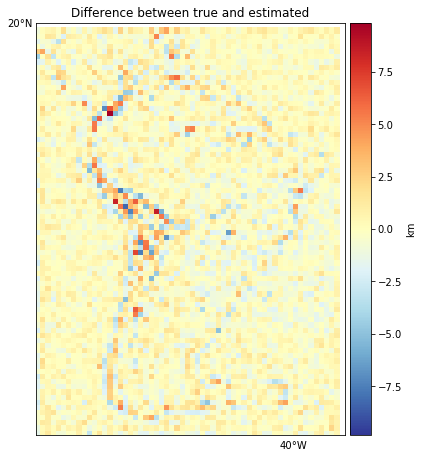

In [112]:
plot_diff(results['solution'], model, bm)

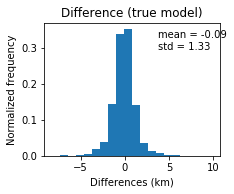

In [113]:
plot_diff_hist(results['solution'], model)

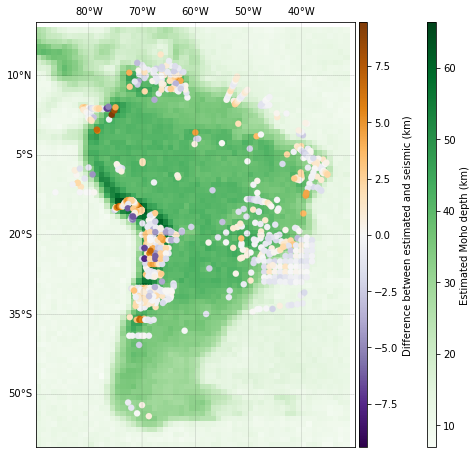

In [114]:
plot_diff_seismic(results['solution'], test_points, bm)

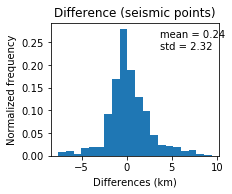

In [115]:
plot_diff_seismic_hist(results['solution'], test_points)

[]()